In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
import seaborn as sns

df_production = pd.read_csv('COMPANY_BASIN_20200128 Producing Entity Monthly Production.CSV')

df_production_group = df_production.groupby('Entity ID')['API/UWI'].agg(['count'])
df_production_group.sort_values('count', ascending=False, inplace=True)

well_1 = df_production_group.index[0]
well_1_prod = df_production[df_production['Entity ID'] == well_1]

In [1]:
def hyperbolic_equation(t, qi, b, di):
    return qi*((1.0+b*((-np.log(1-di))/12)*t)**(-1.0/b))

def exponential_equation(t, qi, di):
    return qi*np.exp(-di*t)

In [20]:
import numpy as np

def calc_effective_decline(rate):
    '''
    Calculates effective decline form rate
    Input:
        np array of (number_instances , n_month) shape - production rate
    Retunrns 
        np array of the same shape that contains effective dicline
    
    '''
    ni = rate.shape[0]
    a = rate
    a[a==0] = 0.000001
    #print(np.min(a))
    b = np.diff(a)
    c = np.abs(1 - np.exp(-b/a[:,:-1]))
    
    return np.hstack([np.full(ni, np.nan).reshape(1,ni).T, c ])

def rate_conditioning(rate, e_d, ip24, Df, abdn):
    '''
    Conditions the rate by two factors:
        Effective decline is greated then given threshold (Df), rate decline calculates with exp quation.
        If rate drops below abondon rate, next to zero value gets assigned.
    Input
        np array of (number_instances , n_month) shape - production rate, effective_dicline
        np arrays ip24, Df, abdn - 1D with number of ellements equal to number of instances
    Output
        condioned rate same as input rate 

    '''
    rate_1 = np.empty_like(rate)

    ni = rate_1.shape[0]
    nt = rate_1.shape[1]

    rate_1[:,0] = ip24

    for ix in range(1, nt, 1):

        c = e_d[:, ix ] > Df/(100*12)
        rate_1[c,ix] = rate[c,ix]

        c_inv = np.invert(c)
        rate_1[c_inv,ix] = rate_1[c_inv,ix-1] * (np.exp(-(-np.log(1-Df[c_inv]/100))/12))

    abdn_m = np.repeat(abdn.reshape(1,ni),rate_1.shape[1], axis=0).T

    rate_1[rate_1 <= abdn_m] = 0.000001
    
    return rate_1

def calc_cum_prod(rate):
    '''
    Turn rate in to cumulative production
    Input
        np array of (number_instances , n_month) shape - production rate
    Output
        cumulative production of the same tyep/shape as input rate array
    '''

    cum_prod = np.empty_like(rate)
    cum_prod[:,0] = 0
    
    rate_ls = np.roll(rate, 1)
    
    # check with Max
    cum_prod[:, 1:] = (rate[:, 1:] + rate_ls[:, 1:]) * 30.42 / (2*1000)
    cum_prod = np.cumsum(cum_prod, axis=1)
    cum_prod[:, 0] = np.nan
    
    return cum_prod

def calc_rate(ip24,b,Di,n_month):
    '''
    Clacultes rates based on hyperbolyc equation.
    Inputs: 
        ip24,b,Di - one dimentional np.arrays number of ellements coresponds to number of rate instances
        t - integer, number of month
    Returns:
        2D np array of following shape (number_instances , n_month)
    '''    
    t    = np.array(range(n_month))
    ni = len(ip24)
    
    a = np.array(b * (-np.log(1 - (Di/100))/12)).reshape(1,ni).T
    a = 1 + np.multiply(t, a)
    b[b == 0] = 0.0000001
    p = np.repeat((-1 / b).reshape(1,ni),a.shape[1], axis=0).T
    rate_v = np.multiply (np.power(a[:,1:], p[:,1:]), ip24.reshape(1,ni).T)

    return np.hstack( [ip24.reshape(1,ni).T, rate_v]), t

def calc_production(ip24,b,Di,Df,abdn,NUMBER_OF_MONTH):
    

    rate, t = calc_rate(ip24,b,Di,NUMBER_OF_MONTH)
    effective_dicline = calc_effective_decline(rate)
    rate_1 = rate_conditioning(rate, effective_dicline, ip24, Df, abdn)
    cum_prod = calc_cum_prod(rate_1)


    return t, rate, effective_dicline, rate_1, cum_prod

In [21]:
def calculate_rates_from_decline(dataframe_parameters):
    
    hc_ip24 = np.asarray(dataframe_parameters['qi'])
    hc_b = np.asarray(dataframe_parameters['b'])
    hc_Di = np.asarray(dataframe_parameters['di'])
    hc_Df = np.asarray(dataframe_parameters['d_f'])
    hc_abdn = np.asarray(dataframe_parameters['abdn'])

    min_date_production = dataframe_parameters['start_production_month'].min()

    months_since_first_production = int(round((pd.to_datetime('2025-12-01')
                                               - pd.to_datetime(min_date_production))
                                               / np.timedelta64(1,'M')+2, 0))

    (time, hc_rate_raw, hc_effective_decline, 
     hc_rate, hc_cum_prod) = calc_production(hc_ip24, hc_b, 
                                             hc_Di, hc_Df, hc_abdn, 
                                             months_since_first_production)
    return hc_rate

In [73]:
well_1

125416799

In [74]:
well_1_prod['Daily Avg Oil'].head()

35145    641.67
35146    500.48
35147    494.77
35148    397.47
35149    256.74
Name: Daily Avg Oil, dtype: float64

In [75]:
# Generate month_online column for decline calculation
well_1_prod['Months_Online'] = list(range(0, len(well_1_prod)))

/var/folders/83/dd1dp6cs4n5b8mt9sjqc20kh0000gn/T/ipykernel_3518/1474811272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_1_prod['Months_Online'] = list(range(0, len(well_1_prod)))


In [76]:
well_1_prod['Months_Online_Shifted'] = (well_1_prod.Months_Online.shift(0, axis=0))

/var/folders/83/dd1dp6cs4n5b8mt9sjqc20kh0000gn/T/ipykernel_3518/2323057701.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_1_prod['Months_Online_Shifted'] = (well_1_prod.Months_Online.shift(0, axis=0))


In [77]:
popt_hyp, pcov_hyp = curve_fit(hyperbolic_equation, 
                               well_1_prod['Months_Online_Shifted'].iloc[0:len(well_1_prod['Months_Online_Shifted'])-6], 
                               well_1_prod['Daily Avg Oil'].iloc[0:len(well_1_prod['Months_Online_Shifted'])-6], 
                                                   bounds=([0, 0.1, 0], [650,2,0.99]))

In [78]:
popt_hyp

array([650.        ,   1.09512533,   0.95423967])

In [79]:
pcov_hyp

array([[6.87934842e+02, 8.54082778e-01, 3.61333872e-01],
       [8.54082778e-01, 6.58771843e-03, 1.23667849e-03],
       [3.61333872e-01, 1.23667849e-03, 3.37262619e-04]])

In [80]:
(time, hc_rate_raw, 
 hc_effective_decline, hc_rate, hc_cum_prod) = calc_production(np.array([popt_hyp[0]]), 
                                                               np.array([popt_hyp[1]]), 
                                                               np.array([popt_hyp[2]*100]), 
                                                               np.array([7.]),
                                                               np.array([1.]), 
                                                               117)

In [81]:
hc_rate.flatten()

array([650.        , 518.27260403, 432.32792547, 371.65822896,
       326.45208978, 291.41302468, 263.42520515, 240.53345514,
       221.44757576, 205.28107774, 191.40431469, 179.35748905,
       168.79683456, 159.46007898, 151.14357297, 143.68672679,
       136.96116492, 130.86300803, 125.30727698, 120.22376701,
       115.55395988, 111.24868091, 107.26629932, 103.57132995,
       100.13333562,  96.92605706,  93.92671737,  91.11546111,
        88.47489881,  85.98973424,  83.64645749,  81.43309063,
        79.33897576,  77.35459734,  75.47143256,  73.68182469,
        71.97887535,  70.35635258,  68.80861189,  67.33052844,
        65.91743827,  64.56508752,  63.26958807,  62.02737896,
        60.83519252,  59.6900247 ,  58.58910887,  57.52989275,
        56.51001797,  55.52730191,  54.57972155,  53.66539912,
        52.78258922,  51.92966731,  51.10511941,  50.30753278,
        49.53558757,  48.78804932,  48.06376206,  47.36164223,
        46.680673  ,  46.01989924,  45.37842287,  44.75

In [82]:
well_1_prod['decline'] = hc_rate.flatten()

/var/folders/83/dd1dp6cs4n5b8mt9sjqc20kh0000gn/T/ipykernel_3518/560235367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_1_prod['decline'] = hc_rate.flatten()


<AxesSubplot:xlabel='Months_Online_Shifted', ylabel='decline'>

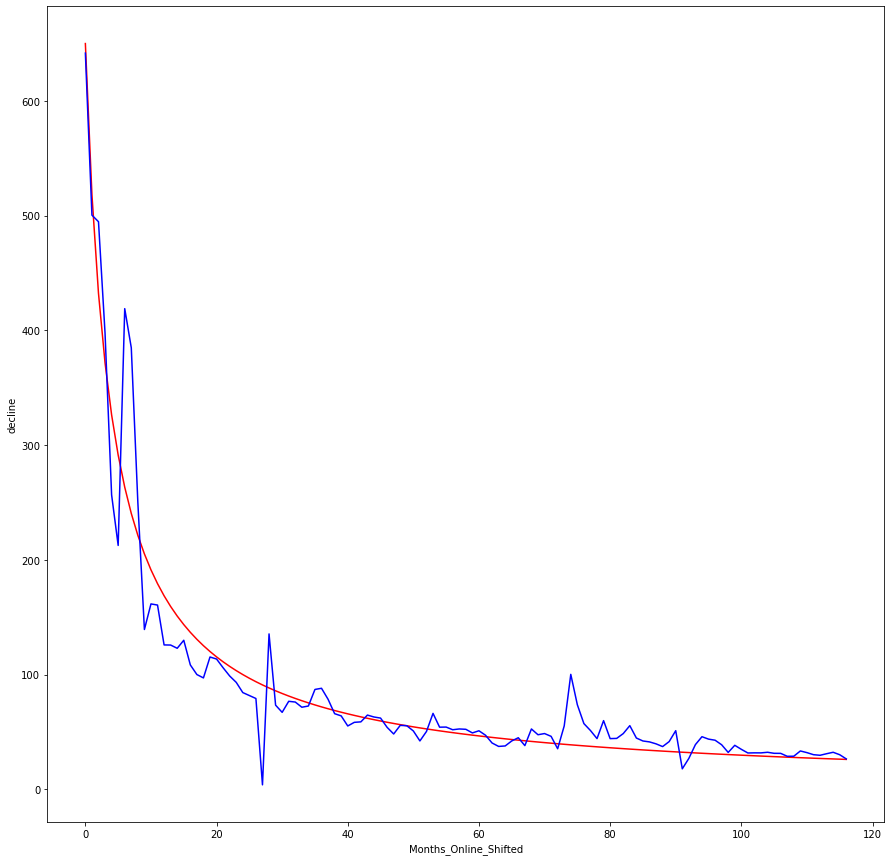

In [83]:
fig = plt.figure(figsize=(15, 15))
sns.lineplot(data = well_1_prod, x='Months_Online_Shifted', y='decline', color='red')
sns.lineplot(data = well_1_prod, x='Months_Online_Shifted', y='Daily Avg Oil', color='blue')

In [84]:
well_1_prod[['Daily Avg Oil', 'decline']].tail(6)

,Daily Avg Oil,decline
35256,30.33,27.257834
35257,29.81,27.042352
35258,31.17,26.830408
35259,32.43,26.621915
35260,30.29,26.416787
35261,26.63,26.214944


In [90]:
metric = well_1_prod['Daily Avg Oil'].tail(6) - well_1_prod['decline'].tail(6)

In [96]:
np.sqrt((metric.values**2).sum() / 6)

3.7602757367095667

In [98]:
acc = (well_1_prod['decline'].tail(6).sum() * 100) / well_1_prod['Daily Avg Oil'].tail(6).sum()

In [99]:
acc

88.7768402265032

In [100]:
train_dates = pd.to_datetime(well_1_prod['Monthly Production Date'])
train_values = well_1_prod['Daily Avg Oil'].astype(float).values.reshape(-1, 1)

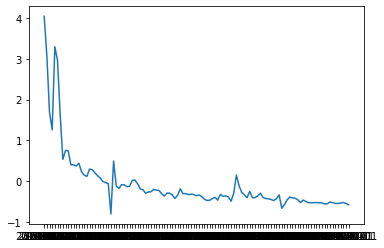

In [101]:
scaler = StandardScaler()
scaler = scaler.fit(train_values)
train_values_scaled = scaler.transform(train_values)
train_values_scaled_t = train_values_scaled[2:]

plt.plot(well_1_prod['Monthly Production Date'].values[2:], train_values_scaled_t)

In [158]:
trainX = []
trainY = []

n_future = 1
n_past = 12

for i in range(n_past, len(train_values_scaled_t) - n_future +1):
    trainX.append(train_values_scaled_t[i - n_past:i])
    trainY.append(train_values_scaled_t[i + n_future - 1:i + n_future])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [159]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (103, 12, 1).
trainY shape == (103, 1, 1).


In [160]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 12, 64)            16896     
_________________________________________________________________
lstm_25 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
6/6 [==============================] - 2s 56ms/step - loss: 0.1312 - val_loss: 0.2555
Epoch 2/5
6/6 [==============================] - 0s 10ms/step - loss: 0.1011 - val_loss: 0.1858
Epoch 3/5
6/6 [==============================] - 0s 9ms

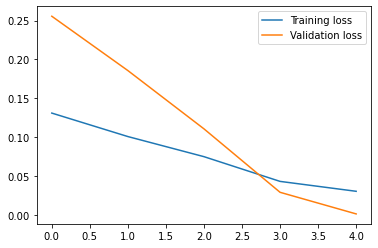

In [161]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

/Users/zorikhin/anaconda3/envs/ds/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zorikhin/anaconda3/envs/ds/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/zorikhin/anaconda3/envs/ds/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or m

<AxesSubplot:xlabel='Date', ylabel='Production'>

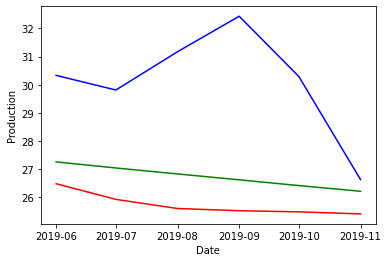

In [162]:
prediction = model.predict(trainX[-6:])
y_pred_future = scaler.inverse_transform(prediction)

df_forecast = pd.DataFrame({'Date':train_dates.iloc[-6:].values, 'Production':y_pred_future.reshape(1, -1).flatten()})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

df_original = pd.DataFrame({'Date':train_dates.iloc[-6:].values, 'Production':train_values[-6:].reshape(1, -1).flatten()})
df_original['Date']=pd.to_datetime(df_forecast['Date'])

sns.lineplot(df_original['Date'], df_original['Production'], color='blue')
sns.lineplot(df_forecast['Date'], df_forecast['Production'], color='red')
sns.lineplot(df_forecast['Date'], well_1_prod['decline'].tail(6).values, color='green')

In [163]:
acc_2 = (df_forecast['Production'].sum() * 100) / df_original['Production'].sum()

In [164]:
acc_2

85.4824880791914